# Outlier Detection Demo
This notebook demonstrates how to perform outlier detection using the MedImageInsight endpoint.

## Overview

This notebook provides a detailed demonstration of outlier detection in medical imaging using the MedImageInsight endpoint. The workflow includes submitting images for embedding extraction, and manipulating these embeddings to derive meaningful features. The notebook uses MedImageInsight to calculate embeddings for individual images, which are then grouped together by study to generate a study-level embedding. This is a powerful use case for MedImageInsight, effectively combining image processing, statistical analysis, and machine learning to detect anomalies in medical imaging data. While the notebook uses a simple setup with a few studies, it showcases the potential of this method for more complex and large-scale applications in medical imaging.

The method shown here is designed to identify abnormal studies, series, or other types of medical image sets. The approach can assess how similar study or series to those in a reference set, which can be considered an "outlier" if it is too different. You can try this approach to various modalities such as CT or MRI scans.

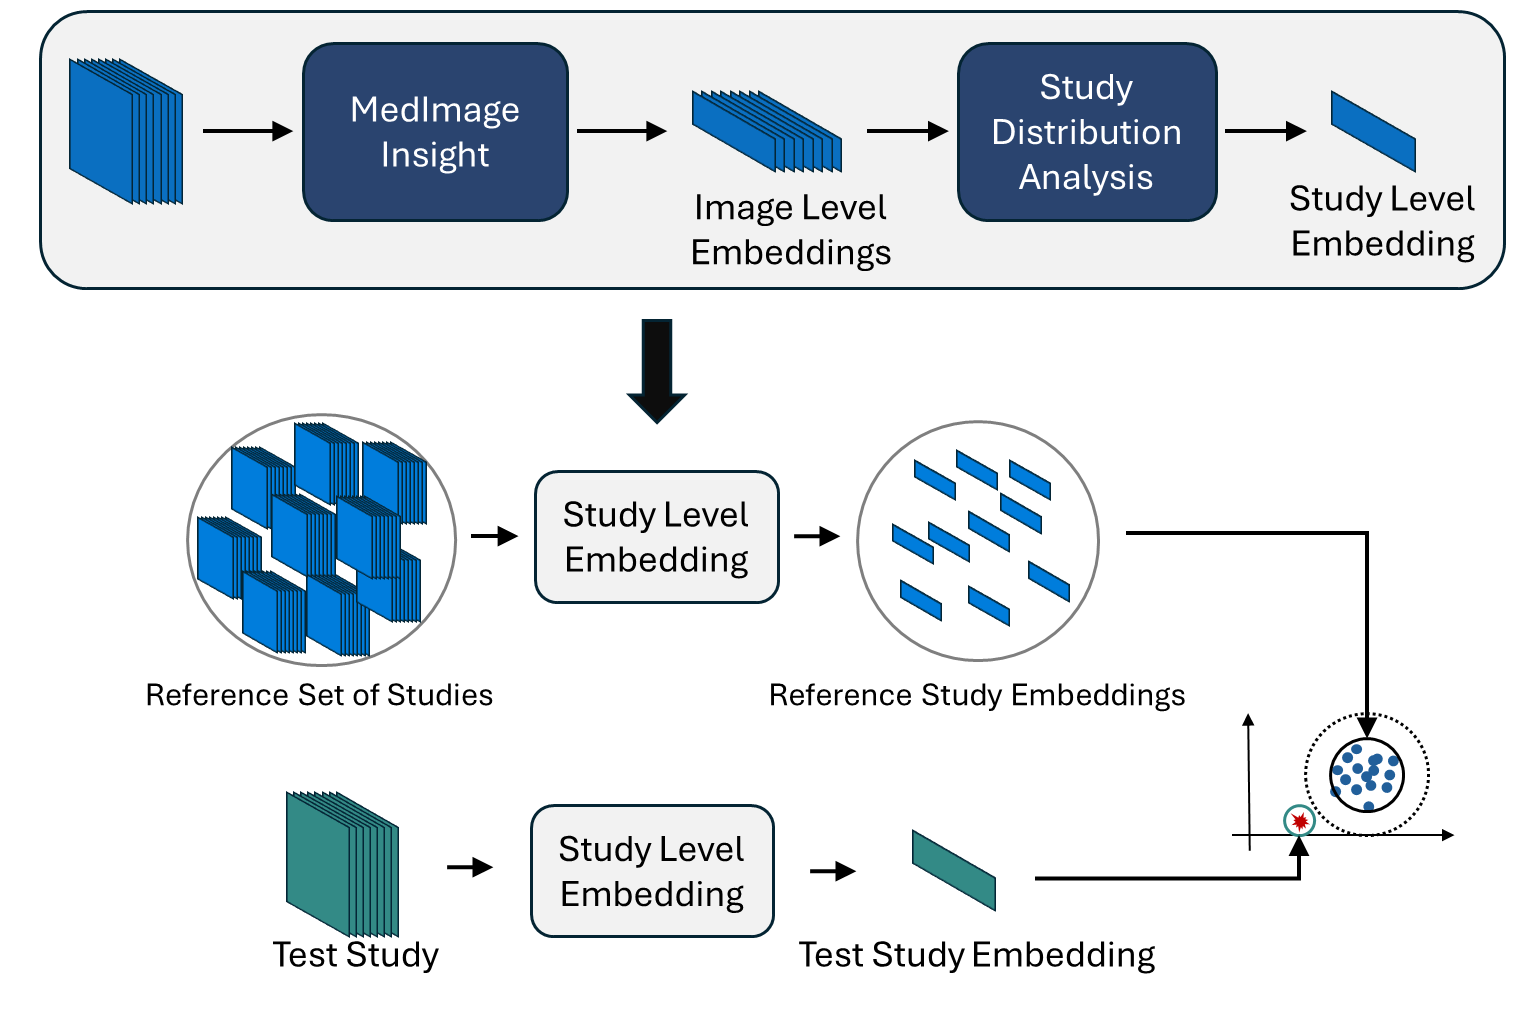

In outline, this process is as follows:
1. Obtain embeddings for a list of dicom images using MedImageInsight.
2. Group images into based on their study.
3. For each study, calculate a study level embedding from the individual image embeddings using basic statistical methods.
4. Fit a KNN model to the reference set of study embeddings.
5. Use the same process to calculate study embeddings for test studies.
6. Determine if the new study is an outlier based on the its distance to the data in the reference set.



## Prerequisites

Before proceeding with the tutorial, you need to perform some initial setup.

### Azure ML Environment
To reproduce the notebook and run the Outlier Detection Demo, use the Azure Machine Learning environment. This provides a streamlined setup and execution experience.

### Dataset
The sample dataset includes medical imaging data and embeddings required for the demo. Please download the dataset using the following command:

```bash
azcopy copy --recursive https://azuremlexampledata.blob.core.windows.net/data/healthcare-ai/ /home/azureuser/data/
```

Organize the downloaded data as follows:
- **DICOM Files**: Located in the `dicoms` directory under the `data` folder.
- **Embeddings File**: A file named `embeddings.jsonl` where embeddings will be saved post-processing.

Ensure the files are correctly placed and accessible in the `data` directory.

### Environment

1. Install the `healthcareai_toolkit` package using the following command:
   ```bash
   pip install -e package
   ```
2. Configure a `.env` file with at least the following parameters:
   - `DATA_ROOT`: Path to your dataset directory.
   - `MI2_MODEL_ENDPOINT`: Endpoint URL for MedImageInsight.

## Outlier Detection Demo Overview
This tutorial will guide you through the steps to perform outlier detection using the MedImageInsight embedding model. Here are the steps we will perform:

1. **Access the MedImageInsight Endpoint**
   - Confirm access to the MedImageInsight endpoint.
   - Specify your endpoint URL and any required authentication parameters in the notebook during client initialization.

2. **Prepare Data for the model**
   - Use the downloaded dataset, organized with DICOM files and embeddings, to collect image level embeddings with MedImageInsight.

3. **Generate Study Level Embeddings**
   - Generate study level embeddings by aggregating image level embeddings using statistical methods.

4. **Perform Outlier Detection**
   - Use the generated embeddings to identify images with abnormal patterns or outliers in the dataset.

5. **Visualize and Interpret Results**
   - Visualize the identified outliers to understand the patterns and validate the effectiveness of the outlier detection process.


## 2. Setup

### 2.1. Import Libraries

In [ ]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import umap
from PIL import Image
from healthcareai_toolkit.clients import MedImageInsightClient
from healthcareai_toolkit import settings

### 2.2. Initialize MedImageInsight Client

We create an instance of the `MedImageInsightClient` using the endpoint URL. This client will be used to submit images for processing and to retrieve embeddings.



In [ ]:
# Initialize the client
endpoint = settings.MI2_MODEL_ENDPOINT
client = MedImageInsightClient(endpoint)

Using ml_client base_url 1: https://management.azure.com
Using ml_client base_url 2: https://management.azure.com


### 2.3. Collect Image Level Embeddings

Using the client, we create a submitter configured to return results as an unordered generator. We then submit the images to the endpoint for processing. As the images are processed, we collect the embeddings and additional metadata, and save them to a JSONL file for later use.

**Note**: We include a check to prevent overwriting existing output file. This file is included in the downloaded data.

**Note**: The DICOM files are not included in the data. Below is an example of how to obtain embeddings for the images to match the format used by this notebook.

In [4]:
data_dir = os.path.join(settings.DATA_ROOT, "medimageinsight-outlier-detection")
output_file = os.path.join(data_dir, "embeddings.jsonl")

# Submit images and save embeddings
if not os.path.isfile(output_file):

    # Define data directories
    dicom_dir = os.path.join(data_dir, "dicoms")

    # Get list of DICOM files
    files = glob.glob(os.path.join(dicom_dir, "**/*.dcm"), recursive=True)
    files = [f for f in files if os.path.isfile(f)]
    print(f"Total DICOM files found: {len(files)}")

    # Create the submitter
    submitter = client.create_submitter(return_as="generator_unordered")

    rel_from = dicom_dir
    with open(output_file, "w") as f:
        for index, result in submitter.submit(image_list=files, total=len(files)):
            path = os.path.relpath(files[index], rel_from)
            row = {
                "path": path,
                "ref": path.startswith("ref"),
                "test": path.startswith("test"),
                "outlier": path.startswith("test/outlier"),
                "StudyInstanceUID": path.split(os.path.sep)[-3],
                "SeriesInstanceUID": path.split(os.path.sep)[-2],
                **result,
            }
            print(json.dumps(row), file=f)
else:
    print(
        f"Output file '{output_file}' already exists. Please remove it if you wish to re-compute the data"
    )

Output file '/home/azureuser/data/healthcare-ai/medimageinsight-outlier-detection/embeddings.jsonl' already exists. Please remove it if you wish to re-compute the data


## 4. Embedding Manipulation

### 4.1. Load Embeddings and Prepare DataFrame

We load the embeddings from the JSONL file into a list of dictionaries. We then construct a pandas DataFrame from this list, facilitating easier data manipulation and analysis.

- **Extract identifiers**: We extract `StudyInstanceUID` and `SeriesInstanceUID` from the file paths, which are essential for grouping and aggregating data.
- **Convert features**: We convert the raw `image_features` into numpy arrays for numerical computations.

In [5]:
# Load embeddings from the output file
with open(output_file, "r") as f:
    lines = [json.loads(line) for line in f]

df = pd.DataFrame(lines)
df["image_features"] = df["image_features"].apply(lambda x: np.array(x))
df.groupby(["ref", "outlier"]).sample(2).sort_values(["ref", "outlier"])

,path,ref,test,outlier,StudyInstanceUID,SeriesInstanceUID,image_features,scaling_factor
4484,test/inlier/CT/1.3.6.1.4.1.55648.0074492857206...,False,True,False,1.3.6.1.4.1.55648.0074492857206336414955255073...,1.3.6.1.4.1.55648.0074492857206336414955255073...,"[[-0.018411746248602867, -0.025572510436177254...",4.513362
4349,test/inlier/CT/1.3.6.1.4.1.55648.0074492857206...,False,True,False,1.3.6.1.4.1.55648.0074492857206336414955255073...,1.3.6.1.4.1.55648.0074492857206336414955255073...,"[[-0.023055637255311012, -0.03107447549700737,...",4.513362
3596,test/outlier/MR/1.3.6.1.4.1.55648.001154240785...,False,True,True,1.3.6.1.4.1.55648.0011542407858151652887310950...,1.3.6.1.4.1.55648.0011542407858151652887310950...,"[[-0.030474551022052765, -0.022650813683867455...",4.513362
3528,test/outlier/MR/1.3.6.1.4.1.55648.001154240785...,False,True,True,1.3.6.1.4.1.55648.0011542407858151652887310950...,1.3.6.1.4.1.55648.0011542407858151652887310950...,"[[-0.03281459957361221, 0.0032683557365089655,...",4.513362
2548,ref/CT/1.3.6.1.4.1.55648.329752201671143838953...,True,False,False,1.3.6.1.4.1.55648.3297522016711438389537350354...,1.3.6.1.4.1.55648.3297522016711438389537350354...,"[[-0.05560978129506111, -0.010636602528393269,...",4.513362
3181,ref/CT/1.3.6.1.4.1.55648.272585961824602358694...,True,False,False,1.3.6.1.4.1.55648.2725859618246023586941004279...,1.3.6.1.4.1.55648.2725859618246023586941004279...,"[[-0.0755009725689888, 0.008824517019093037, -...",4.513362


### 4.2. Group Embeddings by Study

We group the DataFrame by `StudyInstanceUID` to aggregate data at the study level. For each study, we:

- **Aggregate image features**: Combine all image features (embeddings) into a single numpy array.
- **Record labels**: Determine whether the study is part of the test set or reference set, and whether it's an inlier or outlier based on directory naming.

This aggregation is essential for computing study-level statistics and applying the outlier detection algorithm.

In [6]:
# Group by StudyInstanceUID and aggregate features
study_df = df.groupby("StudyInstanceUID").agg(
    {
        "test": "max",
        "ref": "max",
        "outlier": "max",
        "image_features": lambda vals: np.vstack(vals),
    }
)


pd.concat(
    [
        study_df.groupby("ref")["outlier"].value_counts(),
        (study_df.groupby("ref")["outlier"].value_counts(normalize=True)),
    ],
    axis=1,
)

count  proportion
ref   outlier                   
False True        12    0.857143
      False        2    0.142857
True  False       15    1.000000

### 4.3. Compute Study-Level Embedding

We define a function `compute_study_features` that computes statistical measures from the aggregated image features of each study. For this demonstration, we selected the following features based on their distribution statistics:

- **Mean**: Average value of features.
- **Standard Deviation**: Variation or dispersion of features.
- **Min/Max**: Minimum and maximum values.
- **Percentiles**: 25th, 50th (median), and 75th percentiles.

These statistical features serve as an example of how to summarize study-level information. You can customize this selection or experiment with alternative statistical measures depending on the specific requirements of your application. The critical point is to ensure the creation of an embedding for each study, capturing essential information for downstream tasks such as outlier detection.


In [7]:
# Function to compute statistical features
def compute_study_features(x):
    stats = {
        "mean": np.nanmean(x, axis=0),
        "std": np.nanstd(x, axis=0, ddof=1),
        "min": np.nanmin(x, axis=0),
        "25%": np.nanpercentile(x, 25, axis=0),
        "50%": np.nanmedian(x, axis=0),
        "75%": np.nanpercentile(x, 75, axis=0),
        "max": np.nanmax(x, axis=0),
    }
    return np.hstack(list(stats.values()))


# Compute study-level features
study_df["study_features"] = study_df["image_features"].apply(compute_study_features)
study_df["study_features"].iloc[0].shape

(7168,)

### 4.4 Embedding Visualization

Inliers shape: (1700, 7168), Outliers shape: (1200, 7168)


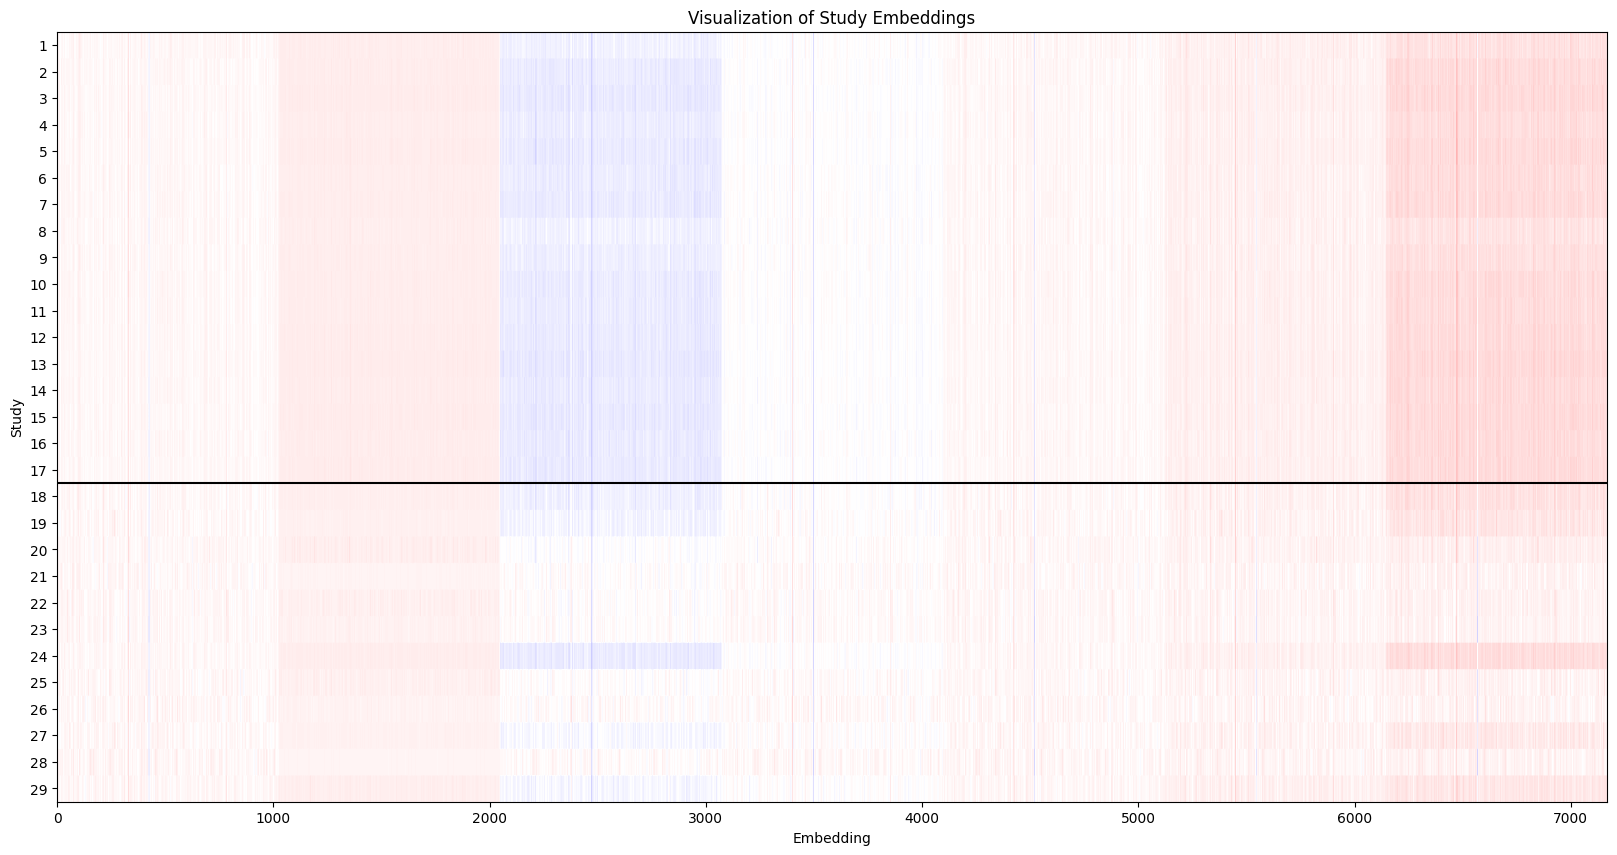

In [8]:
# Visualize features
tile_value = 100
study_df = study_df.sort_values("test")
ims = defaultdict(list)
for _, row in study_df.iterrows():
    im = np.tile(row["study_features"], (tile_value, 1))
    ims[row["outlier"]].append(im)

inliers = np.vstack(ims[False])
outliers = np.vstack(ims[True])
stack = np.vstack([inliers, outliers])

print(f"Inliers shape: {inliers.shape}, Outliers shape: {outliers.shape}")

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(stack, aspect="auto", cmap="bwr")
ax.axhline(y=len(inliers), color="k")

# Set y-ticks
num_ticks = stack.shape[0] // tile_value
ax.set_yticks([i * tile_value + tile_value / 2 for i in range(num_ticks + 1)])
ax.set_yticklabels([str(i + 1) for i in range(num_ticks + 1)])
ax.set_ylim([stack.shape[0], 0])

ax.set_ylabel("Study")
ax.set_xlabel("Embedding")

ax.set_title("Visualization of Study Embeddings")
plt.show()

### 4.4 Visual Study Images

The following sections shows some example images from the input studies.

In [9]:
study_info_file = os.path.join(data_dir, "study_info.csv")
study_info = pd.read_csv(study_info_file)
study_info["bodyParts"] = study_info["bodyParts"].fillna("UNK")

sample_dir = os.path.join(data_dir, "samples")


def plot_study_images(study_uids, figmult=10):
    img_show_df = study_info[study_info["StudyInstanceUID"].isin(study_uids)]
    for study, grp in img_show_df.groupby("StudyInstanceUID"):
        fig, axes = plt.subplots(
            1,
            len(grp),
            figsize=(figmult, figmult * len(grp)),
            gridspec_kw={"wspace": 0.01},
        )
        if not isinstance(axes, np.ndarray):
            axes = [axes]

        for i, (ax, (_, row)) in enumerate(zip(axes, grp.iterrows())):
            imfile = row["sample_image"]
            img = Image.open(os.path.join(sample_dir, imfile))
            ax.imshow(img, cmap="gray")
            ax.axis("off")
            if i == 0:
                ax.set_title(row["modalities"] + "-" + row["bodyParts"], loc="left")
            fig.show()

#### 4.4.1 Reference Set

Our reference set is comprised of CT-ABDOMEN images which provide cross-sectional views of the abdomen. These images typically cover the area from the diaphragm to the pelvis, capturing vital organs such as the liver, spleen, pancreas, kidneys, and intestines.

Below, we are visualizing 3 studies by showing the middle image  of each of the series.


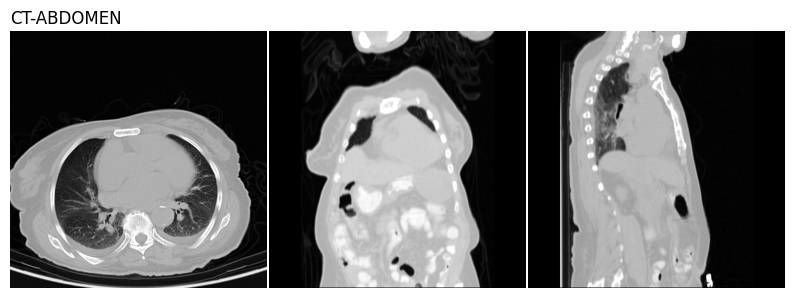

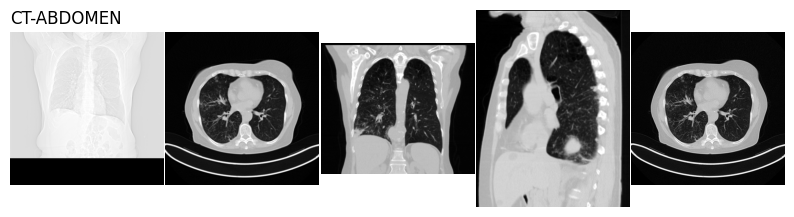

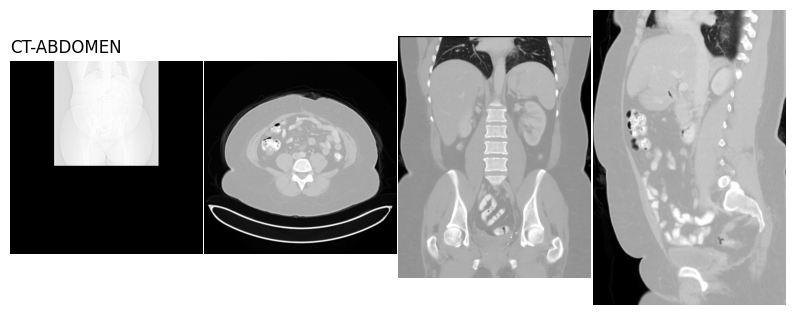

In [10]:
# Display some studies from the reference set
ref_uids = study_info.query("ref")["StudyInstanceUID"].unique().tolist()[-3:]
plot_study_images(ref_uids)

#### 4.4.2 Test Set

Our test set is comprised of various modalities including MR, CR, DX, NM, MG, and CT. These images cover different body parts such as CHEST, SPINE, and forearm, providing a diverse set of medical imaging data for outlier detection.

Below, we are visualizing some of these studies.

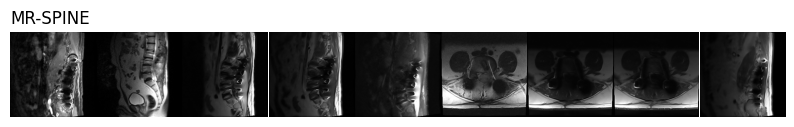

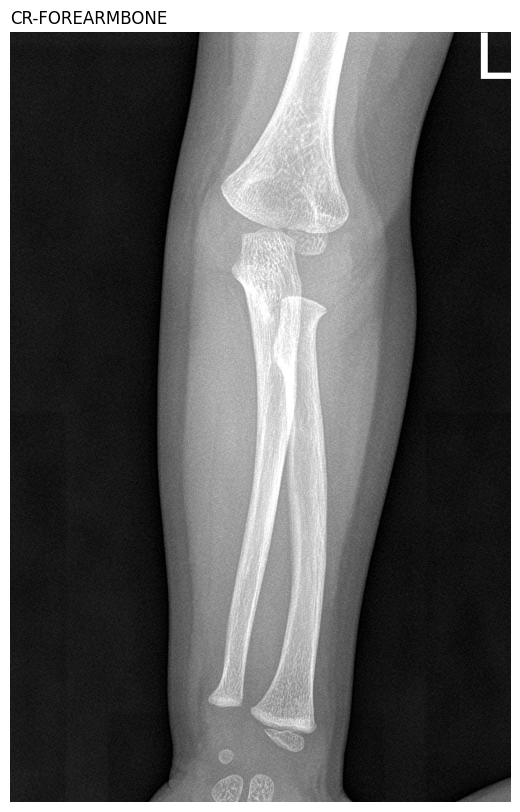

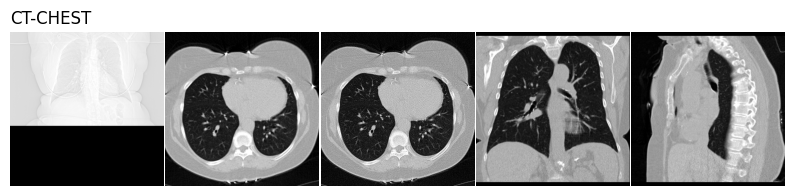

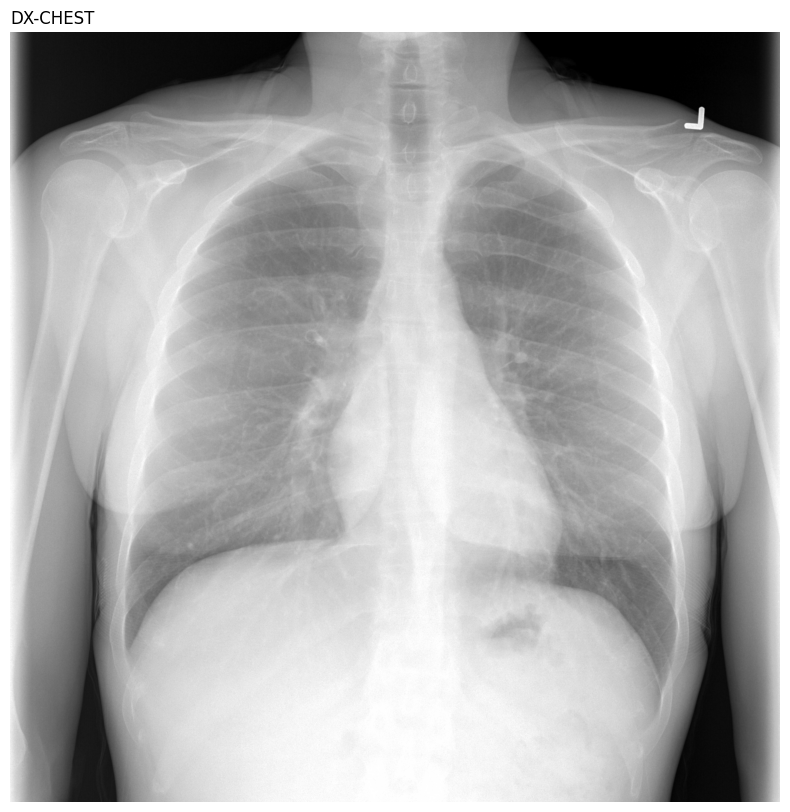

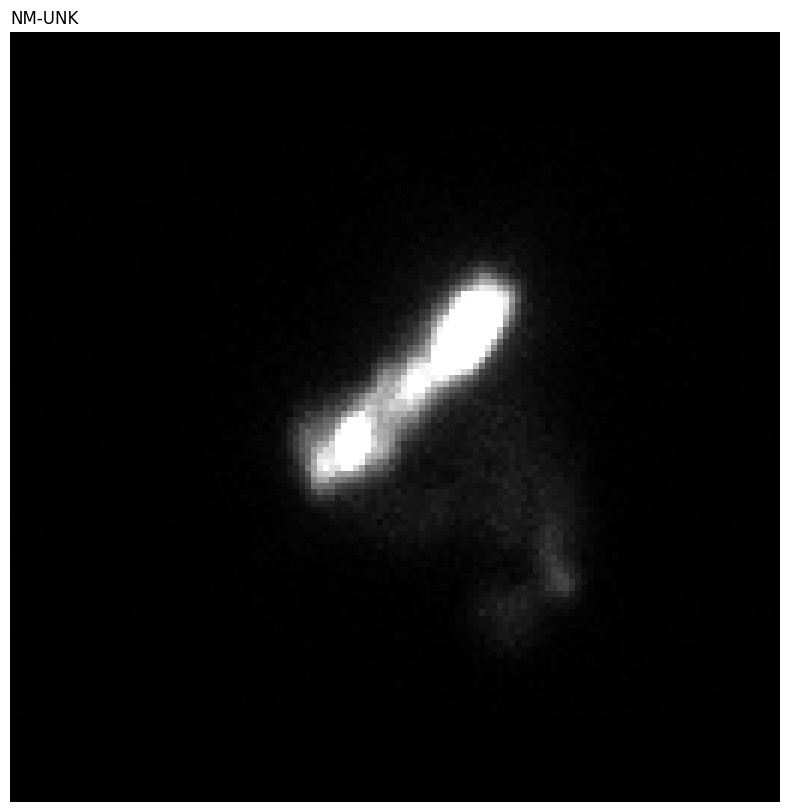

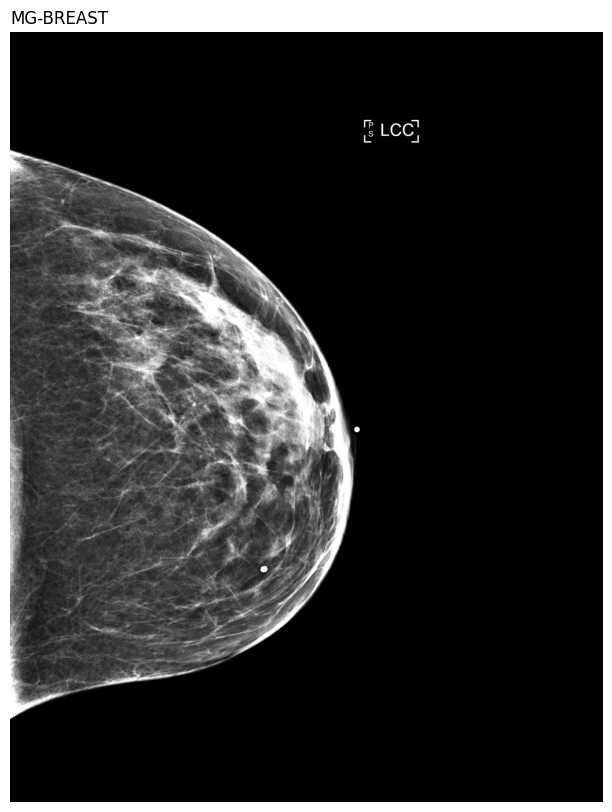

In [11]:
# Display some studies from the test set
test_uids = study_info.query("~ref").groupby("modalities")["StudyInstanceUID"].first()
plot_study_images(test_uids)

## 5. Outlier Detection

We use machine learning techniques to detect outliers based on the computed study-level features.

### 5.1. Perform Outlier Detection Using Nearest Neighbors

We perform outlier detection by:

1. **Splitting the data**: Separate the dataset into a reference set (inliers) and a test set (mixture of inliers and outliers).
2. **Training the model**: Fit a Nearest Neighbors model using the study features from the reference set.
3. **Computing distances**: For each study, compute the distance to its nearest neighbors in the reference set. These distances serve as anomaly scores.
4. **Determining thresholds**: Compute the ROC curve to evaluate the model's performance at various threshold levels and select an optimal threshold for classifying outliers.

By comparing the distances to the optimal threshold, we classify studies as inliers or outliers.
We also plot the Receiver Operating Characteristic (ROC) curve to visualize the trade-off between the true positive rate and false positive rate at different thresholds.

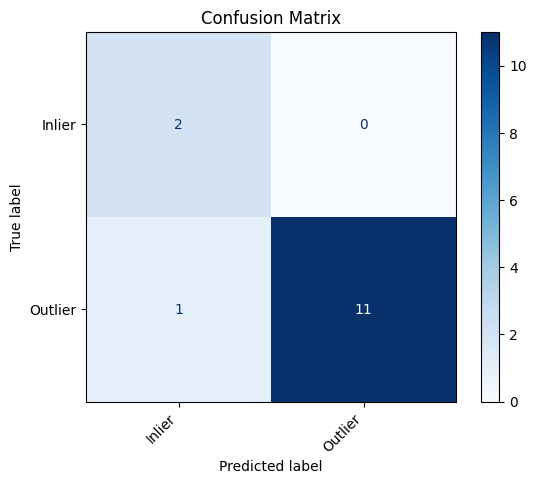

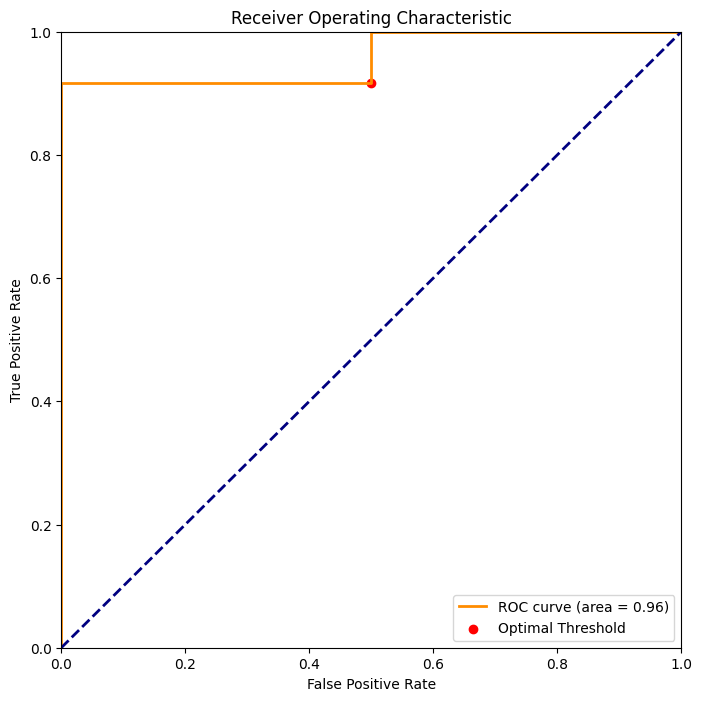

In [13]:
# Split into reference and test sets
ref_set = study_df[~study_df["test"]]
test_set = study_df[study_df["test"]]
X_ref = np.vstack(ref_set["study_features"])
X_all = np.vstack(study_df["study_features"])
X_test = np.vstack(test_set["study_features"])


# Fit Nearest Neighbors model
nbrs = NearestNeighbors(n_neighbors=2).fit(X_ref)
distances, indices = nbrs.kneighbors(X_test)
scores = np.mean(distances, axis=1)

study_df.loc[study_df["test"], "neighbor1"] = ref_set.iloc[indices[:, 0]].index
study_df.loc[study_df["test"], "neighbor2"] = ref_set.iloc[indices[:, 1]].index

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(study_df.loc[study_df["test"], "outlier"], scores)


def get_optimal_idx(tpr, fpr, w_tpr=1.0, w_fpr=1.0):
    return np.argmin(np.sqrt(w_tpr * (1 - tpr) ** 2 + w_fpr * fpr**2)) + 1


optimal_idx = get_optimal_idx(tpr, fpr)
optimal_threshold = thresholds[optimal_idx]

# Determine outliers
outliers = scores > optimal_threshold
study_df["predicted_outlier"] = False
study_df.loc[study_df["test"], "predicted_outlier"] = outliers
test_set = study_df[study_df["test"]]


# Calculate and show confusion matrix
cm = confusion_matrix(test_set["outlier"], test_set["predicted_outlier"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Inlier", "Outlier"])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label="Optimal Threshold")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

### 5.2. Evaluate Model Performance


### 5.3. Apply UMAP and Visualize Embedding

We apply UMAP to the high-dimensional study features to reduce them to two dimensions. This allows us to:

- **Visualize the data**: Plot the studies on a 2D plane to observe clusters and separations.
- **Interpret clusters**: Identify if inliers and outliers form distinct clusters, which would support the effectiveness of our feature extraction and outlier detection methods.

In [14]:
# Extract the study features
study_features = np.vstack(study_df["study_features"])

# Fit and transform the data using UMAP
reducer = umap.UMAP()
reducer.fit(X_all)

embedding = reducer.transform(X_all)

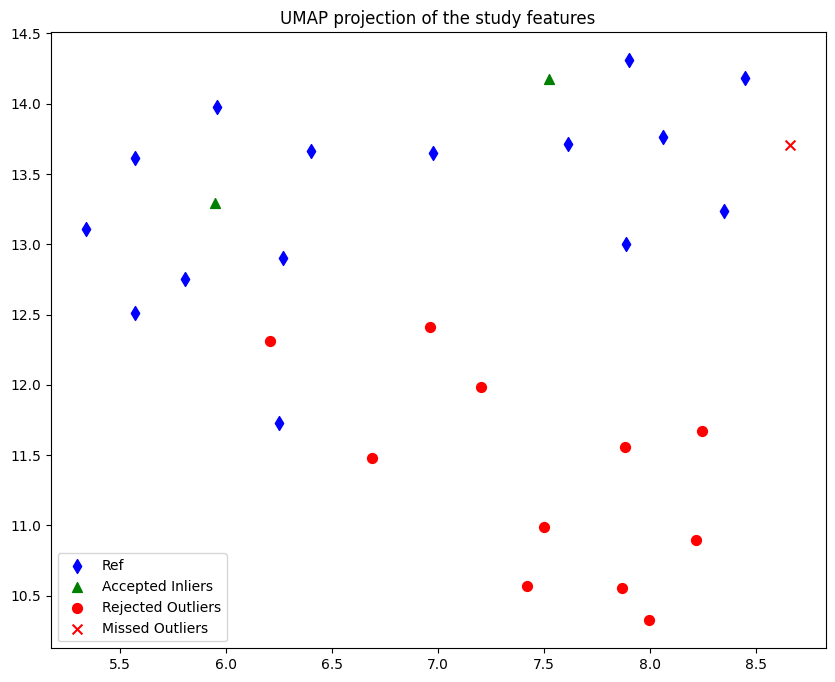

In [15]:
# Plot the UMAP embedding with markers for reference and colors for inlier
plt.figure(figsize=(10, 8))
markers_colors = {
    "Ref": ("d", "blue"),
    "Missed Outliers": ("x", "red"),
    "Rejected Outliers": ("o", "red"),
    "Accepted Inliers": ("^", "green"),
    "Rejected Inliers": ("x", "orange"),
}


ref_condition = study_df["test"] == False
outlier_condition = study_df["outlier"]
accepted_condition = study_df["predicted_outlier"] == False

categories = {
    "Ref": ref_condition,
    "Accepted Inliers": accepted_condition & ~outlier_condition & ~ref_condition,
    "Rejected Inliers": ~accepted_condition & ~outlier_condition & ~ref_condition,
    "Rejected Outliers": ~accepted_condition & outlier_condition & ~ref_condition,
    "Missed Outliers": accepted_condition & outlier_condition & ~ref_condition,
}

for category, condition in categories.items():
    subset = condition
    indices = subset.values.tolist()
    if subset.sum():
        plt.scatter(
            embedding[indices, 0],
            embedding[indices, 1],
            c=markers_colors[category][1],
            marker=markers_colors[category][0],
            label=category,
            s=50,
        )

plt.legend()
plt.title("UMAP projection of the study features")
plt.show()

### 5.4. Missed Outliers

The next two cells show the missed outliers and their nearest neighbors (closest images to the error). As you can see, this study is extremely similar to these images, which end a bit higher than typical ABDOMEN studies. This error could be corrected by having a tighter cluster of images for the reference set.

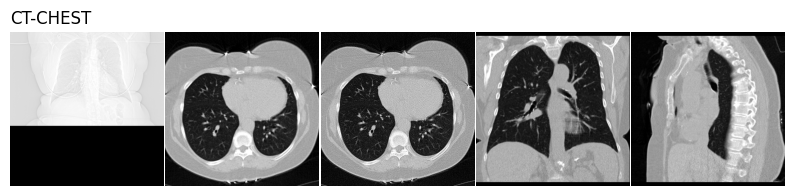

In [16]:
# Display the missed outliers
missed_outliers = categories["Missed Outliers"][categories["Missed Outliers"]]
missed_outliers_uids = missed_outliers.index.tolist()
plot_study_images(missed_outliers_uids)

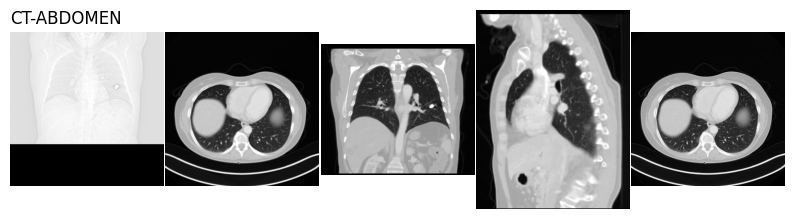

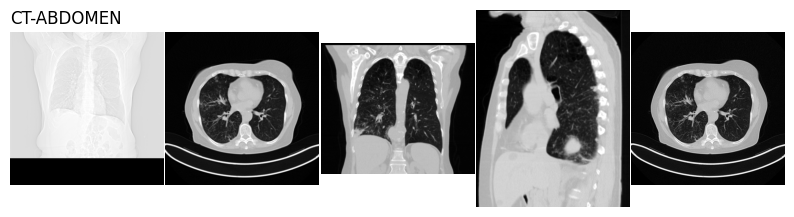

In [17]:
neighbor_uids = (
    test_set[test_set.index.isin(missed_outliers_uids)][["neighbor1", "neighbor2"]]
    .values.ravel()
    .tolist()
)
plot_study_images(neighbor_uids)

## Final Remarks

This notebook provides a detailed demonstration of outlier detection in medical imaging using the MedImageInsight endpoint. We showed how to submit images for embedding extraction and manipulate these embeddings to derive meaningful features. By calculating embeddings for individual images and grouping them by study to generate a study-level embedding, we effectively combined image processing, statistical analysis, and machine learning to detect anomalies in medical imaging data. Although we used a simple setup with a few studies, this method showcases the potential for more complex and large-scale applications in medical imaging.

The approach demonstrated here is designed to identify abnormal studies, series, or other types of medical image sets by assessing how similar they are to those in a reference set. If a study or series is significantly different, it can be considered an "outlier." This method can be applied to various modalities such as CT or MR scans.

These concepts have wide-ranging applications across research, clinical workflows, and clinical operations, offering valuable tools for improving outcomes and operational effectiveness.

### Potential Research Applications

In research settings, automating image quality assessment is crucial for reliable and generalizable findings. This utility can:

- **Perform Automatic Quality Control:** Detect suboptimal imaging studies with motion artifacts, poor resolution, or inconsistent protocols less manual intervention.
- **Pre-process for Analysis:** Select only high-quality images for advanced analytical pipelines, reducing noise and variability.
- **Standardize Across Datasets:** Ensure consistency in multi-center studies by standardizing imaging quality from various institutions or equipment.
- **Gain Cluster-Based Insights:** Identify patterns or outliers in image quality through clustering, informing protocol refinements.

**Benefits:**

- Improved generalizability and reproducibility of research findings.
- Reduced manual workload for researchers.
- Data-driven optimization of imaging protocols.

**Next Steps:**

- Evaluate performance using your own labeled datasets.
- Try customized clustering dimensions for relevant quality metrics.

### Potential AI Workflows

For AI-driven screening programs, reducing wasted time in image processing is essential. This process could be used to:

- **Eliminate Redundant Processing:** Pre-clustering images ensures only necessary data proceeds through the AI pipeline, avoiding reprocessing irrelevant images.
- **Design Intelligent Workflows:** Identifies inefficiencies and suggests optimized pathways, reducing unnecessary steps.
- **Automate Quality Filtering:** Flags suboptimal or irrelevant studies before they enter the AI workflow.
- **Optimize Resource Allocation:** Categorizes images by computational requirements to prevent system overloads.

**Benefits:**

- Increased processing speed and scalability.
- Cost efficiency through saved computational resources.
- Enhanced transparency in workflows.

**Next Steps:**

- Explore hierarchical clustering for task categorization.
- Integrate adaptive feedback loops based on real-time data.

### Clinical Quality Validation

In clinical settings, ensuring adherence to standardized exam protocols is vital. This utility can:

- **Monitor Protocol Compliance:** Automatically clusters imaging data based on protocol parameters and compares them against standards.
- **Prevent and Correct Errors:** Flags deviations immediately for prompt correction by technicians.
- **Perform Pre-Report Quality Checks:** Identifies incomplete or incorrect studies before they reach radiologists.
- **Optimize Workflow Efficiency:** Prioritizes correctly executed exams to reduce delays and improve patient throughput.

**Benefits:**

- Improved diagnostic accuracy through reduced variability.
- Operational efficiency via automated validation.
- Reduced need for repeat scans, minimizing patient inconvenience and exposure.

**Next Steps:**

- Deploy for real-time workflow monitoring.
- Customize clustering to clinical protocol requirements.

